In [1]:
import matplotlib.pyplot as plt

# Step 1: Load and tokenize data
data = []

with open('parallel-n/IITB.en-hi.en', 'r', encoding='utf-8') as f_en, \
     open('parallel-n/IITB.en-hi.hi', 'r', encoding='utf-8') as f_hi:

    for en_line, hi_line in zip(f_en, f_hi):
        en_tokens = en_line.strip().split()
        hi_tokens = hi_line.strip().split()
        data.append((en_tokens, hi_tokens))  # Save for later use


In [2]:
# Step 2: Compute sentence lengths
en_lengths = [len(en) for en, _ in data]
hi_lengths = [len(hi) for _, hi in data]

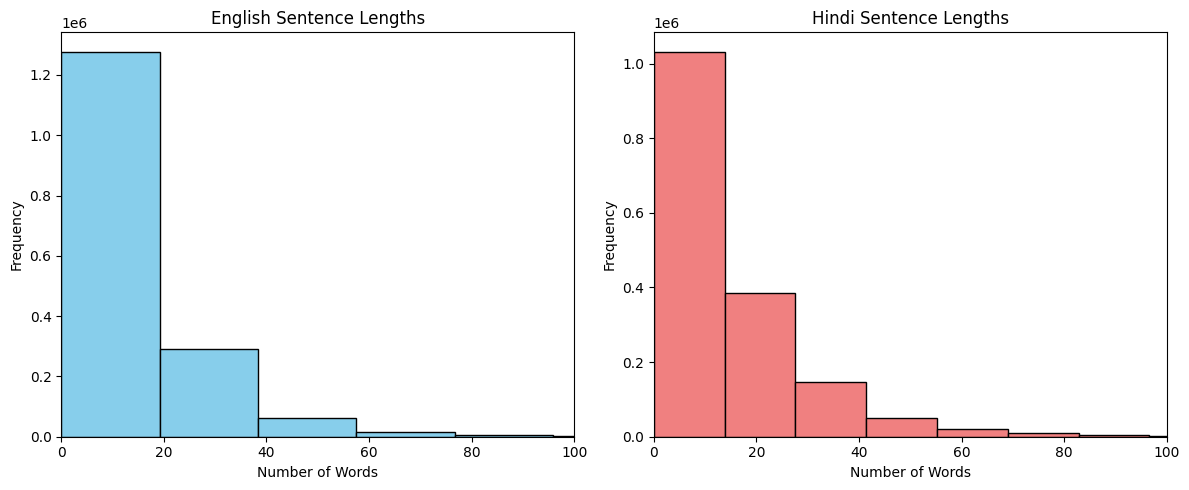

In [3]:
# Step 3: Plot histograms (cropped to 250 words)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(en_lengths, bins=100, color='skyblue', edgecolor='black')
plt.title('English Sentence Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, 100)  # Crop here

plt.subplot(1, 2, 2)
plt.hist(hi_lengths, bins=100, color='lightcoral', edgecolor='black')
plt.title('Hindi Sentence Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, 100)  # Crop here

plt.tight_layout()
plt.show()


In [4]:
filtered_data = [
    (en, hi) for en, hi in data
    if 20 <= len(hi) <= 30
]
print(f"Found {len(filtered_data)} sentence pairs with Hindi length between 20 and 30 words")


Found 225478 sentence pairs with Hindi length between 20 and 30 words


In [5]:
print(filtered_data[0])

(['Accerciser', 'could', 'not', 'see', 'the', 'applications', 'on', 'your', 'desktop.', 'You', 'must', 'enable', 'desktop', 'accessibility', 'to', 'fix', 'this', 'problem.', 'Do', 'you', 'want', 'to', 'enable', 'it', 'now?'], ['एक्सेरसाइसर', 'आपके', 'डेस्कटोप', 'में', 'मौजूद', 'अनुप्रयोग', 'नहीं', 'देख', 'पाया।', 'इस', 'समस्या', 'के', 'समाधान', 'के', 'लिए', 'आपको', 'डेस्कटोप', 'पहुंचनीयता', 'को', 'सक्रिय', 'करना', 'होगा।', 'क्या', 'आप', 'इसे', 'सक्रिय', 'करना', 'चाहते', 'हैं?'])


In [6]:
import re
import sentencepiece as spm
from pathlib import Path

# Your data: [[english_tokens, hindi_tokens], ...]
# Example: data = [["i", "am", "happy"], ["मैं", "खुश", "हूँ"]]

def clean_data(data):
    """Clean English and Hindi tokens in the data."""
    cleaned_data = []
    for eng_tokens, hin_tokens in data:
        # Clean English: lowercase, remove non-alphanumeric
        eng_clean = [re.sub(r'[^a-z0-9\s]', '', t.lower()) for t in eng_tokens if t]
        eng_clean = [t for t in eng_clean if t]  # Remove empty
        # Clean Hindi: keep Devanagari, remove others
        hin_clean = [re.sub(r'[^\u0900-\u097F\s।]', '', t) for t in hin_tokens if t]
        hin_clean = [t for t in hin_clean if t]
        cleaned_data.append([' '.join(eng_clean), ' '.join(hin_clean)])  # Join tokens back to sentences
    return cleaned_data

def train_tokenizer(cleaned_data, vocab_size=14000, model_prefix='en_hi'):
    """Train SentencePiece tokenizer and create vocab."""
    # Write English and Hindi to temporary files
    with open('temp_en.txt', 'w', encoding='utf-8') as f_en, \
         open('temp_hi.txt', 'w', encoding='utf-8') as f_hi:
        for eng_sent, hin_sent in cleaned_data:
            f_en.write(eng_sent + '\n')
            f_hi.write(hin_sent + '\n')
    
    # Train SentencePiece model
    spm.SentencePieceTrainer.train(
        input='temp_en.txt,temp_hi.txt',  # Combined English and Hindi
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        character_coverage=1.0,  # Full coverage for Hindi
        model_type='bpe'  # Byte-Pair Encoding
    )
    
    # Load the trained tokenizer
    sp = spm.SentencePieceProcessor()
    sp.load(f'{model_prefix}.model')
    return sp

def tokenize_data(cleaned_data, tokenizer):
    """Tokenize cleaned data using the trained tokenizer."""
    tokenized_data = []
    for eng_sent, hin_sent in cleaned_data:
        eng_tokens = tokenizer.encode_as_pieces(eng_sent)  # Subword tokens
        hin_tokens = tokenizer.encode_as_pieces(hin_sent)
        tokenized_data.append([eng_tokens, hin_tokens])
    return tokenized_data





In [7]:
cleaned_data = clean_data(filtered_data)

In [8]:
tokenizer = train_tokenizer(cleaned_data, vocab_size=12000)

In [9]:
tokenized_data = tokenize_data(cleaned_data, tokenizer)

In [10]:
print(tokenized_data[0])

[['▁acc', 'erc', 'is', 'er', '▁could', '▁not', '▁see', '▁the', '▁applications', '▁on', '▁your', '▁des', 'k', 't', 'op', '▁you', '▁must', '▁enable', '▁des', 'k', 't', 'op', '▁access', 'ibility', '▁to', '▁f', 'ix', '▁this', '▁problem', '▁do', '▁you', '▁want', '▁to', '▁enable', '▁it', '▁now'], ['▁एक', '्', 'से', 'र', 'साइ', 'सर', '▁आपके', '▁डे', 'स्', 'कट', 'ोप', '▁में', '▁मौजूद', '▁अनुप्रयोग', '▁नहीं', '▁देख', '▁पाया', '।', '▁इस', '▁समस्या', '▁के', '▁समाधान', '▁के', '▁लिए', '▁आपको', '▁डे', 'स्', 'कट', 'ोप', '▁पहुंच', 'नीय', 'ता', '▁को', '▁सक्रिय', '▁करना', '▁होगा', '।', '▁क्या', '▁आप', '▁इसे', '▁सक्रिय', '▁करना', '▁चाहते', '▁हैं']]


In [11]:
import numpy as np

def tokens_to_ids(tokenized_data, tokenizer, max_len=32):
    """Convert tokenized data to numerical IDs with padding/truncation."""
    numerical_data = []

    vocab_size = tokenizer.get_piece_size()

    pad_id = tokenizer.pad_id()
    if pad_id == -1:
        pad_id = 0

    bos_id = tokenizer.bos_id()
    eos_id = tokenizer.eos_id()

    for eng_tokens, hin_tokens in tokenized_data:
        # Convert tokens to IDs
        eng_ids = tokenizer.encode_as_ids(' '.join(eng_tokens))
        hin_ids = tokenizer.encode_as_ids(' '.join(hin_tokens))

        # English: truncate to (max_len - 2), then add BOS and EOS
        eng_ids = eng_ids[:max_len - 2]
        eng_ids = [bos_id] + eng_ids + [eos_id]
        eng_ids += [pad_id] * (max_len - len(eng_ids))  # Final length = 32

        # Hindi: truncate to (max_len - 1), then add BOS and EOS
        hin_ids = hin_ids[:max_len - 1]
        hin_ids = [bos_id] + hin_ids + [eos_id]
        hin_ids += [pad_id] * (max_len + 1 - len(hin_ids))  # Final length = 33

        numerical_data.append([eng_ids, hin_ids])

    return numerical_data


def filter_by_length(numerical_data, tokenizer, min_len=10, max_len=32):
    """Filter out pairs where unpadded length is outside min_len to max_len."""
    filtered_data = []
    pad_id = tokenizer.pad_id()
    if pad_id == -1:
        pad_id = 0

    for eng_ids, hin_ids in numerical_data:
        eng_len = sum(1 for id_ in eng_ids if id_ != pad_id)
        hin_len = sum(1 for id_ in hin_ids if id_ != pad_id)

        if min_len <= eng_len <= max_len and min_len <= hin_len <= (max_len + 1):
            filtered_data.append([eng_ids, hin_ids])

    return filtered_data


In [12]:
numerical_data = tokens_to_ids(tokenized_data, tokenizer, max_len=32)

In [14]:
# Step 2: Filter by length (10–32 tokens)
filtered_numerical_data = filter_by_length(numerical_data, tokenizer,min_len=10, max_len=32)

In [16]:
# Step 3: Convert to numpy arrays (optional, for tensor feeding)
numerical_arrays = np.array(filtered_numerical_data,dtype=object)  # Shape: (num_pairs, 2, max_len)

In [17]:
print(filtered_numerical_data[0])

[[1, 685, 2877, 11897, 99, 2877, 1271, 215, 1117, 10, 7320, 134, 473, 921, 204, 4, 1437, 152, 1416, 6962, 921, 204, 4, 1437, 3304, 8188, 1259, 60, 37, 305, 11943, 2], [1, 140, 11873, 11887, 83, 62, 8069, 519, 1787, 3070, 279, 5202, 11873, 1757, 57, 3683, 6385, 205, 757, 3890, 1884, 128, 2273, 21, 4313, 21, 142, 1804, 3070, 279, 5202, 11873, 2]]


In [18]:
np.save('numerical_data.npy', numerical_arrays)

In [34]:
numerical_arrays = np.load('numerical_data.npy', allow_pickle=True)
filtered_numerical_data = numerical_arrays.tolist()

In [35]:
english = []
hindi = []

for en, hi in filtered_numerical_data:
    english.append(en)
    hindi.append(hi)

In [38]:
import torch
import torch.nn
from transformer import Transformer
from encoder.encoder import Encoder
from decoder.decoder import Decoder
from utils.embedding_layer import EmbeddingLayer
from utils.positional_embedding import PositionalEmbedding

dim_model = 128
n_heads = 8
dim_ff = 512
dropout = 0.1
vocab_size = 12000
n_encoder_layers = 5
n_decoder_layers = 5
max_len = 32
batch_size = 64
learning_rate = 0.001
epochs = 20
device='cpu'
position = PositionalEmbedding(max_len,dim_model,device)
epochs=20
def train():
    # Initialize model components
    embedding_layer_encoder = EmbeddingLayer(vocab_size, dim_model,None, device)
    embedding_layer_decoder = EmbeddingLayer(vocab_size, dim_model,None,  device)
    encoder = Encoder(dim_model, n_heads, dim_ff, n_encoder_layers, dropout,device)
    decoder = Decoder(dim_model, n_heads, dim_ff, n_decoder_layers, dropout,device)
    transformer = Transformer(encoder, decoder)

    # Move model to device
    transformer.to(device)

    # Define loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(transformer.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        transformer.train()
        total_loss = 0.0

        for i in range(0, len(english), batch_size):
            eng_batch = torch.tensor(english[i:i+batch_size], dtype=torch.long).to(device)
            hin_batch = torch.tensor(hindi[i:i+batch_size], dtype=torch.long).to(device)
            
            encoded_english = embedding_layer_encoder(eng_batch)
            encoded_hindi = embedding_layer_decoder(hin_batch[:, :-1])
            for j in range(hin_batch.shape[1]-1):
                encoded_hindi[:, j, :] += position(j).to(device)
            for j in range(eng_batch.shape[1]):
                encoded_english[:, j, :] += position(j).to(device)

            # Forward pass
            optimizer.zero_grad()
            output = transformer(encoded_english, encoded_hindi) 

            # Compute loss
            loss = criterion(output.view(-1, vocab_size), hin_batch[:, 1:].view(-1))  # Exclude first token
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(english)}")
train()

IndexError: index out of range in self